In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import Bbox
import statsmodels.api as sm
from scipy import stats
from utils import *
import pandas as pd

### univariate regressions

In [12]:
liu=xr.open_dataset('../data/bootstrap/liu2023.nc')

In [2]:
# read in data and calc regressions
mdls=['cesm1','cesm2','mpige','mpi12']
yys=[[1960,1989],[1989,2018],[2073,2099]]
cf=24*60*60*365
ms={mdl:{} for mdl in mdls}
rs={mdl:{} for mdl in mdls}
for mdl in mdls:
    if 'mpi' in mdl:
        la=xr.open_dataset('mpi_mask_grnlnd_antarc.nc').landarea
    else:
        la=xr.open_dataset('mask_grnlnd_antarc.nc').landarea
    latrop=la.where(abs(la.lat)<24)
    f='../data/globann/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)
    for yy in yys:
        ix=get_ix(ds,yy[0],yy[1])
        midyear=int(np.floor(np.mean(yy)))
        x=1e-9*latrop.sum()*detrend_dim(ds.SW_TROP.isel(year=ix),'year')
        y=1e-9*la.sum()*cf*detrend_dim(ds.NBP.isel(year=ix),'year')
        m=[stats.linregress(x,y)[0] for x,y in zip(x,y)]
        r=[stats.linregress(x,y)[2] for x,y in zip(x,y)]
        ms[mdl][midyear]=m
        rs[mdl][midyear]=r
    

### some numbers bits we needed in the main text

In [4]:
print('1989-2018 average slope:')
for mdl in mdls:
    print(mdl,np.round(np.mean(ms[mdl][2003]),2))

1989-2018 average slope:
cesm1 1.17
cesm2 0.62
mpige 1.79
mpi12 1.7


In [5]:
print('1989-2018 average correlation:')
for mdl in mdls:
    print(mdl,np.round(np.mean(rs[mdl][2003]),2))

1989-2018 average correlation:
cesm1 0.44
cesm2 0.58
mpige 0.76
mpi12 0.75


In [6]:
mnames={'cesm1': 'CESM1', 'cesm2': 'CESM2', 'mpige': 'MPI-GE', 'mpi12': 'MPI-1.2'}
s=''
u=' PgC yr-1 per TtH2O'
for mdl in mdls:
    q1,q2=np.quantile(ms[mdl][2003],[0.05,0.95])
    q1=str(np.round(q1,2))
    q2=str(np.round(q2,2))
    s+=q1+'-'+q2+u+' for '+mnames[mdl]+', '
print(s)

0.62-2.14 PgC yr-1 per TtH2O for CESM1, 0.35-0.92 PgC yr-1 per TtH2O for CESM2, 1.27-2.41 PgC yr-1 per TtH2O for MPI-GE, 1.27-2.25 PgC yr-1 per TtH2O for MPI-1.2, 


In [7]:
for mdl in mdls:
    delta=int(np.round(100*(np.mean(ms[mdl][2003])/np.mean(ms[mdl][1974]))-100))
    print(mdl,str(delta)+'%')

cesm1 -5%
cesm2 11%
mpige -7%
mpi12 2%


In [8]:
s=''
for mdl in ['cesm2','mpige','mpi12']:
    s+=mnames[mdl]+' (average slope change from '
    s+=str(np.round(np.mean(ms[mdl][2003]),2))
    s+=' to '
    s+=str(np.round(np.mean(ms[mdl][2086]),2))
    s+='), '
s

'CESM2 (average slope change from 0.62 to 0.39), MPI-GE (average slope change from 1.79 to 1.47), MPI-1.2 (average slope change from 1.7 to 1.14), '

### making the plot

In [9]:
df=pd.read_csv('sigs.txt',header=None) #computed in slopes.ipynb
yrs=np.unique(df[1].values)
sigs={mdl:{} for mdl in mdls}
for mdl,yr,mark in zip(df[0],df[1],df[2]):
    sigs[mdl][yr]=mark

In [10]:
import matplotlib as mpl
cmap = mpl.colormaps['plasma']
cp = list(cmap(np.linspace(0, 1, 8))[2:8:2])

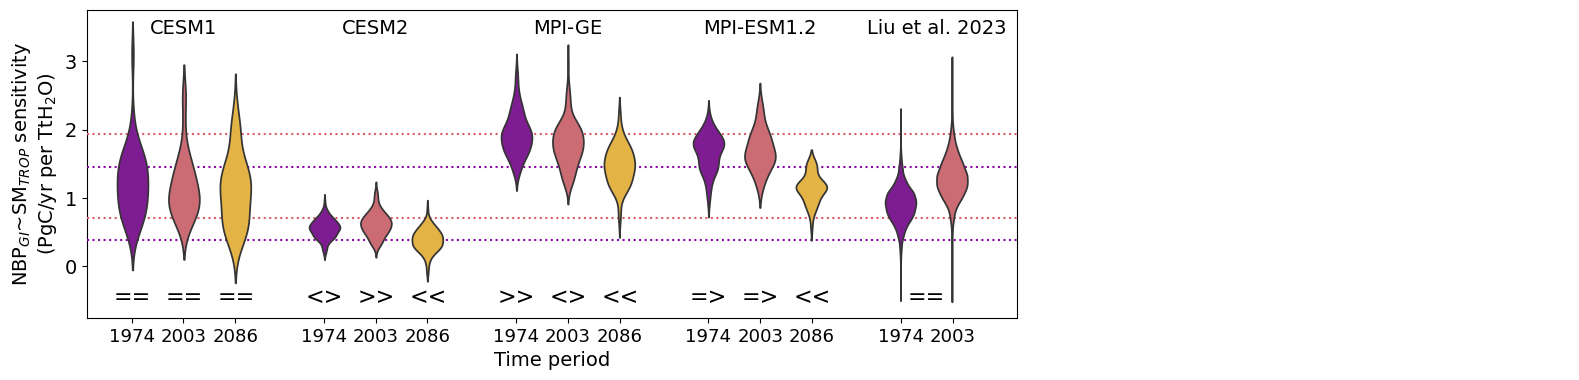

In [22]:
fig, ax1 = plt.subplots(ncols=1,figsize=[12,4])
ax= fig.add_subplot(111, sharex=ax1, sharey=ax1, label="ax2")
ax.axis('off')
qx=0.025
for i in range(2):
    for qq in [qx,1-qx]:
        q=-liu.slopes.isel(period=i).quantile(qq)
        ax.plot([-1,100],[q,q],':',color=cp[i])

mnames={'cesm1':'CESM1','cesm2':'CESM2','mpige':'MPI-GE','mpi12':'MPI-ESM1.2'}
xshift=0.16
for i,mdl in enumerate(mdls):
    ax= fig.add_subplot(111, sharex=ax1, sharey=ax1, label="ax2")
    pos = ax.get_position()
    newpos = Bbox.from_bounds(0.12+i*xshift, pos.y0, 0.6, pos.height)
    ax.set_position(newpos)
    ax.axis('off')
    
    sns.violinplot(ms[mdl],ax=ax,palette=cp,inner=None,width=0.6)
    plt.text(1,3.4,mnames[mdl],ha='center',fontsize=14)

    xs=np.array([-0.123,0.87,1.87])+0.12
    for j in range(3):
        plt.text(xs[j]+j*0.01,-0.55,sigs[mdl][yrs[j]],fontsize=16,ha='center')


i+=1
ax= fig.add_subplot(111, sharex=ax1, sharey=ax1, label="ax2")
pos = ax.get_position()
newpos = Bbox.from_bounds(0.12+i*xshift, pos.y0, 0.6, pos.height)
ax.set_position(newpos)
ax.axis('off')
sns.violinplot(-liu.slopes.T,ax=ax,palette=cp[:-1],inner=None,width=0.6)
plt.text(0.7,3.4,'Liu et al. 2023',ha='center',fontsize=14)
plt.text(0.5,-0.55,'==',ha='center',fontsize=16)

    
plt.xlim([-1,13])
xv=[i*2.895+j*0.78-0.33 for i in range(5) for j in range(3)]
ax1.set_xticks(xv[:-1],np.tile(yrs,5)[:-1],fontsize=13);
plt.ylim([-0.75,3.75])

yy=np.arange(4)
ax1.set_yticks(yy,yy,fontsize=14)
ax1.set_ylabel('NBP$_{GI}$~SM$_{TROP}$ sensitivity \n(PgC/yr per TtH$_2$O)',fontsize=14);
ax1.set_xlabel('Time period',fontsize=14);

plt.savefig('../figs/main/fig1.png',dpi=300,bbox_inches='tight')

In [67]:
#calculating the correlation coefficients from Liu bootstraps
liu_corrs=[[np.corrcoef(x,y)[0,1] for x,y in zip(x,y)] for x,y in zip(liu.TWC_dt,liu.CGR_dt)]
lc={yy:-np.array(c) for yy,c in zip([1974,2003],liu_corrs)}

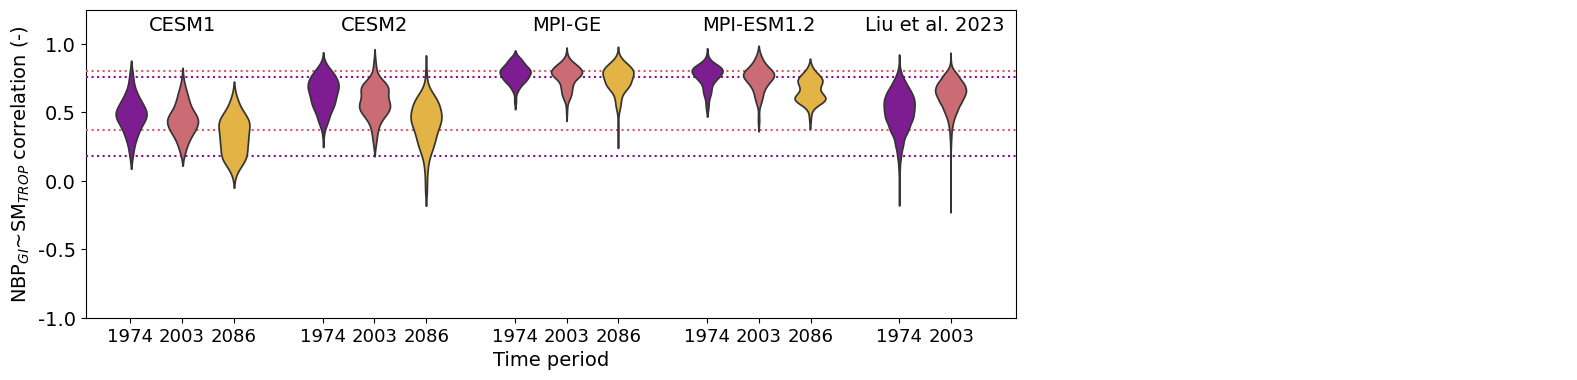

In [68]:
fig, ax1 = plt.subplots(ncols=1,figsize=[12,4])
ax= fig.add_subplot(111, sharex=ax1, sharey=ax1, label="ax2")
ax.axis('off')
qx=0.025
for i,yy in enumerate(lc):
    for qq in [qx,1-qx]:
        q=np.quantile(lc[yy],qq)
        ax.plot([-1,100],[q,q],':',color=cp[i])

mnames={'cesm1':'CESM1','cesm2':'CESM2','mpige':'MPI-GE','mpi12':'MPI-ESM1.2'}
xshift=0.16
for i,mdl in enumerate(mdls):
    ax= fig.add_subplot(111, sharex=ax1, sharey=ax1, label="ax2")
    pos = ax.get_position()
    newpos = Bbox.from_bounds(0.12+i*xshift, pos.y0, 0.6, pos.height)
    ax.set_position(newpos)
    ax.axis('off')
    
    sns.violinplot(rs[mdl],ax=ax,palette=cp,inner=None,width=0.6)
    plt.text(1,1.1,mnames[mdl],ha='center',fontsize=14)

i+=1
ax= fig.add_subplot(111, sharex=ax1, sharey=ax1, label="ax2")
pos = ax.get_position()
newpos = Bbox.from_bounds(0.12+i*xshift, pos.y0, 0.6, pos.height)
ax.set_position(newpos)
ax.axis('off')
sns.violinplot(lc,ax=ax,palette=cp[:-1],inner=None,width=0.6)
plt.text(0.7,1.1,'Liu et al. 2023',ha='center',fontsize=14)

plt.xlim([-1,13])
xv=[i*2.895+j*0.78-0.33 for i in range(5) for j in range(3)]
ax1.set_xticks(xv[:-1],np.tile(yrs,5)[:-1],fontsize=13);
plt.ylim([-1,1.25])

yy=np.arange(5)/2-1
ax1.set_yticks(yy,yy,fontsize=14)
ax1.set_ylabel('NBP$_{GI}$~SM$_{TROP}$ correlation (-)',fontsize=14);
ax1.set_xlabel('Time period',fontsize=14);

plt.savefig('../figs/supp/nbp_smtrop_corr_violins.png',dpi=300,bbox_inches='tight')

### deprecated

In [9]:
for mdl in ms:
    for yy in ms[mdl]:
        print(mdl,yy,np.round(np.mean(ms[mdl][yy]),2))

cesm1 1974 1.23
cesm1 2003 1.17
cesm1 2086 1.11
cesm2 1974 0.56
cesm2 2003 0.62
cesm2 2086 0.39
mpige 1974 1.93
mpige 2003 1.79
mpige 2086 1.47
mpi12 1974 1.67
mpi12 2003 1.7
mpi12 2086 1.14


In [23]:
liu={1974:[0.68,1.22],
     2003:[1.03,1.49]}
for yy in [1974,2003]:
    print('liu  ',yy,str(liu[yy][0])+'-'+str(liu[yy][1]))
    for mdl in ms:
        qqs=np.round(np.quantile(ms[mdl][yy],[0.05,0.95]),2)
        print(mdl,yy,str(qqs[0])+'-'+str(qqs[1]))
    

liu   1974 0.68-1.22
cesm1 1974 0.61-1.87
cesm2 1974 0.32-0.76
mpige 1974 1.43-2.5
mpi12 1974 1.19-2.04
liu   2003 1.03-1.49
cesm1 2003 0.62-2.14
cesm2 2003 0.35-0.92
mpige 2003 1.27-2.41
mpi12 2003 1.27-2.25


In [33]:
for mdl in ms:
    print(mdl,str(int(np.round(100*np.mean(ms[mdl][2003])/np.mean(ms[mdl][1974])-100)))+'%')

cesm1 -5%
cesm2 11%
mpige -7%
mpi12 2%


In [51]:
mdls=['cesm1','cesm2','mpige','mpi12']
yys=[[1960,1989],[1989,2018],[2073,2099]]
cf=24*60*60*365
rs={mdl:{} for mdl in mdls}
for mdl in mdls:
    latrop=la.where(abs(la.lat)<24)
    f='../data/globann/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)
    for yy in yys:
        ix=get_ix(ds,yy[0],yy[1])
        midyear=int(np.floor(np.mean(yy)))
        x=detrend_dim(ds.SW_TROP.isel(year=ix),'year')
        y=detrend_dim(ds.NBP.isel(year=ix),'year')
        r=[stats.linregress(x,y)[2] for x,y in zip(x,y)]
        rs[mdl][midyear]=r
    

In [54]:
### bootstrap vs. LENS

In [3]:
import joblib
from joblib import Parallel, delayed

In [4]:
client=get_cluster(25)

In [5]:
def getxy(mdl,yy):
    cf=24*60*60*365
    if 'mpi' in mdl:
        la=xr.open_dataset('mpi_mask_grnlnd_antarc.nc').landarea
    else:
        la=xr.open_dataset('mask_grnlnd_antarc.nc').landarea
    latrop=la.where(abs(la.lat)<24)
    f='../data/globann/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)

    ix=get_ix(ds,yy[0],yy[1])
    midyear=int(np.floor(np.mean(yy)))
    x=1e-9*latrop.sum()*detrend_dim(ds.SW_TROP.isel(year=ix),'year')
    y=1e-9*la.sum()*cf*detrend_dim(ds.NBP.isel(year=ix),'year')

    return x,y

In [6]:
def bsm(x,y,ee):
    r=xr.DataArray(np.random.randint(27,size=[5000,27]),dims=['bs','year'])
    mb=[stats.linregress(x,y)[0] for x,y in zip(x.sel(ens=ee).isel(year=r),y.sel(ens=ee).isel(year=r))]
    return np.std(mb)

In [8]:
client.cluster

PBSCluster(5bb0588a, 'tcp://128.117.208.69:42009', workers=9, threads=9, memory=83.79 GiB)

In [14]:
yys=[[1960,1989],[1989,2018],[2073,2099]]

In [20]:
mdl='mpige'
yy=yys[2]
x,y=getxy(mdl,yy)
with joblib.parallel_config(backend="dask"):
    results = Parallel(verbose=1)(delayed(bsm)(x,y,ee) for ee in x.ens)
mle=[stats.linregress(x,y)[0] for x,y in zip(x,y)]
mlstd=np.std(mle)
(np.array(results)<mlstd).sum()

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 25 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.7s finished


70

64

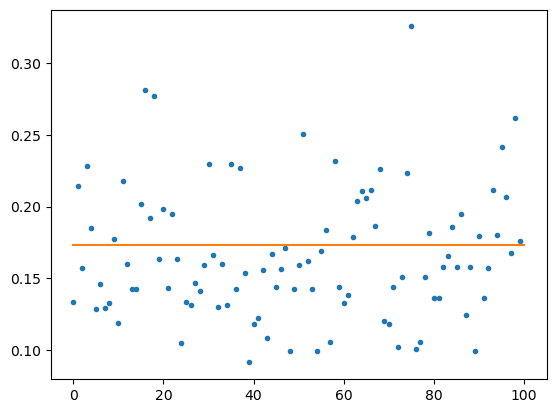

In [109]:
plt.plot(results,'.')
plt.plot([0,len(results)],[mlstd,mlstd])

In [101]:


bsm(x,y,x.ens[12])

0.16230505796143932

In [99]:
np.std(mb)

0.15728526518230637

In [55]:
# read in data and calc regressions
mdls=['cesm1','cesm2','mpige','mpi12']
yys=[[1960,1989],[1989,2018],[2073,2099]]
cf=24*60*60*365
ms={mdl:{} for mdl in mdls}
rs={mdl:{} for mdl in mdls}
for mdl in mdls:
    if 'mpi' in mdl:
        la=xr.open_dataset('mpi_mask_grnlnd_antarc.nc').landarea
    else:
        la=xr.open_dataset('mask_grnlnd_antarc.nc').landarea
    latrop=la.where(abs(la.lat)<24)
    f='../data/globann/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)
    for yy in yys:
        ix=get_ix(ds,yy[0],yy[1])
        midyear=int(np.floor(np.mean(yy)))
        x=1e-9*latrop.sum()*detrend_dim(ds.SW_TROP.isel(year=ix),'year')
        y=1e-9*la.sum()*cf*detrend_dim(ds.NBP.isel(year=ix),'year')
        m=[stats.linregress(x,y)[0] for x,y in zip(x,y)]
        r=[stats.linregress(x,y)[2] for x,y in zip(x,y)]
        ms[mdl][midyear]=m
        rs[mdl][midyear]=r

In [78]:
mb=[[stats.linregress(x,y)[0] for x,y in zip(x.sel(ens=ee).isel(year=r),y.sel(ens=ee).isel(year=r))] for ee in x.ens]


(0.0, 0.4)

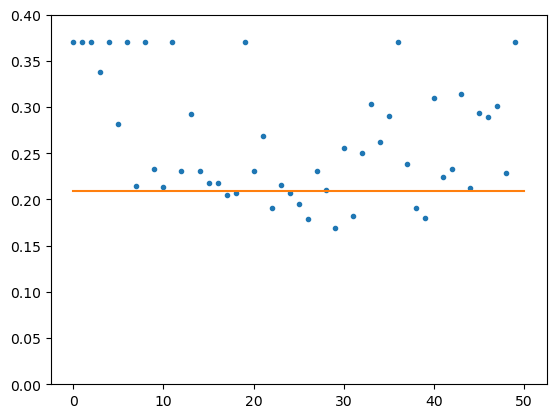

In [84]:
mlstd=np.std(ms[mdl][midyear])
plt.plot(np.array(mb).std(axis=1),'.')
plt.plot([0,50],[mlstd,mlstd])
plt.ylim([0,0.4])

### bivariate regressions

In [25]:
ds.ens

<xarray.DataArray 'ens' (ens: 100)>
array(['cmip6.LE2-1001.001', 'cmip6.LE2-1021.002', 'cmip6.LE2-1041.003',
       'cmip6.LE2-1061.004', 'cmip6.LE2-1081.005', 'cmip6.LE2-1101.006',
       'cmip6.LE2-1121.007', 'cmip6.LE2-1141.008', 'cmip6.LE2-1161.009',
       'cmip6.LE2-1181.010', 'cmip6.LE2-1231.001', 'cmip6.LE2-1231.002',
       'cmip6.LE2-1231.003', 'cmip6.LE2-1231.004', 'cmip6.LE2-1231.005',
       'cmip6.LE2-1231.006', 'cmip6.LE2-1231.007', 'cmip6.LE2-1231.008',
       'cmip6.LE2-1231.009', 'cmip6.LE2-1231.010', 'cmip6.LE2-1251.001',
       'cmip6.LE2-1251.002', 'cmip6.LE2-1251.003', 'cmip6.LE2-1251.004',
       'cmip6.LE2-1251.005', 'cmip6.LE2-1251.006', 'cmip6.LE2-1251.007',
       'cmip6.LE2-1251.008', 'cmip6.LE2-1251.009', 'cmip6.LE2-1251.010',
       'cmip6.LE2-1281.001', 'cmip6.LE2-1281.002', 'cmip6.LE2-1281.003',
       'cmip6.LE2-1281.004', 'cmip6.LE2-1281.005', 'cmip6.LE2-1281.006',
       'cmip6.LE2-1281.007', 'cmip6.LE2-1281.008', 'cmip6.LE2-1281.009',
       'cmip6.LE2-1281.010', 'cmip6.LE2-1301.001', 'cmip6.LE2-1301.002',
       'cmip6.LE2-1301.003', 'cmip6.LE2-1301.004', 'cmip6.LE2-1301.005',
       'cmip6.LE2-1301.006', 'cmip6.LE2-1301.007', 'cmip6.LE2-1301.008',
       'cmip6.LE2-1301.009', 'cmip6.LE2-1301.010', 'smbb.LE2-1011.001',
       'smbb.LE2-1031.002', 'smbb.LE2-1051.003', 'smbb.LE2-1071.004',
       'smbb.LE2-1091.005', 'smbb.LE2-1111.006', 'smbb.LE2-1131.007',
       'smbb.LE2-1151.008', 'smbb.LE2-1171.009', 'smbb.LE2-1191.010',
       'smbb.LE2-1231.011', 'smbb.LE2-1231.012', 'smbb.LE2-1231.013',
       'smbb.LE2-1231.014', 'smbb.LE2-1231.015', 'smbb.LE2-1231.016',
       'smbb.LE2-1231.017', 'smbb.LE2-1231.018', 'smbb.LE2-1231.019',
       'smbb.LE2-1231.020', 'smbb.LE2-1251.011', 'smbb.LE2-1251.012',
       'smbb.LE2-1251.013', 'smbb.LE2-1251.014', 'smbb.LE2-1251.015',
       'smbb.LE2-1251.016', 'smbb.LE2-1251.017', 'smbb.LE2-1251.018',
       'smbb.LE2-1251.019', 'smbb.LE2-1251.020', 'smbb.LE2-1281.011',
       'smbb.LE2-1281.012', 'smbb.LE2-1281.013', 'smbb.LE2-1281.014',
       'smbb.LE2-1281.015', 'smbb.LE2-1281.016', 'smbb.LE2-1281.017',
       'smbb.LE2-1281.018', 'smbb.LE2-1281.019', 'smbb.LE2-1281.020',
       'smbb.LE2-1301.011', 'smbb.LE2-1301.012', 'smbb.LE2-1301.013',
       'smbb.LE2-1301.014', 'smbb.LE2-1301.015', 'smbb.LE2-1301.016',
       'smbb.LE2-1301.017', 'smbb.LE2-1301.018', 'smbb.LE2-1301.019',
       'smbb.LE2-1301.020'], dtype='<U18')
Coordinates:
  * ens      (ens) <U18 'cmip6.LE2-1001.001' ... 'smbb.LE2-1301.020'
    z_t      float32 ...

In [5]:

mdls=['cesm1','cesm2','mpige','mpi12']
yys=[[1960,1989],[1989,2018],[2073,2099]]
msav={mdl:{} for mdl in mdls}
for mdl in mdls:
    if 'mpi' in mdl:
        la=xr.open_dataset('mpi_mask_grnlnd_antarc.nc').landarea
    else:
        la=xr.open_dataset('mask_grnlnd_antarc.nc').landarea
    latrop=la.where(abs(la.lat)<24)
    f='../data/globann/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)
    
    for yy in yys:
        ix=get_ix(ds,yy[0],yy[1])
        yr=int(np.floor(np.mean(yy)))
        
        cfs={}
        cfs['SW_TROP']=1e-9*latrop.sum().values
        cfs['TSA_TROP']=1
        cfs['NBP']=1e-9*la.sum().values*24*60*60*365
        
        xvs=['SW_TROP','TSA_TROP']
        ms=[]
        for ee in range(len(ds.ens)):
            x=np.vstack([cfs[v]*detrend_dim(ds[v].isel(year=ix,ens=ee),'year').values.ravel() for v in xvs]).T
            y=cfs['NBP']*detrend_dim(ds.NBP.isel(year=ix,ens=ee),'year').values.ravel()
            lm=sm.OLS(y,x).fit()
            ms.append(lm.params)
        msav[mdl][yr]=ms

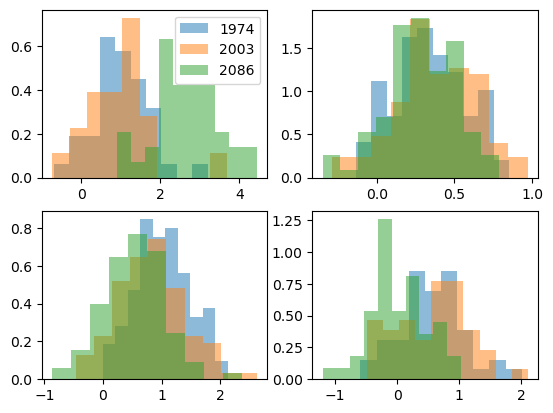

In [8]:
for i,mdl in enumerate(mdls):
    plt.subplot(221+i)
    for yr in msav['cesm2']:
        plt.hist([m[0] for m in msav[mdl][yr]],density=True,alpha=0.5,label=yr)
    if i==0:
        plt.legend()

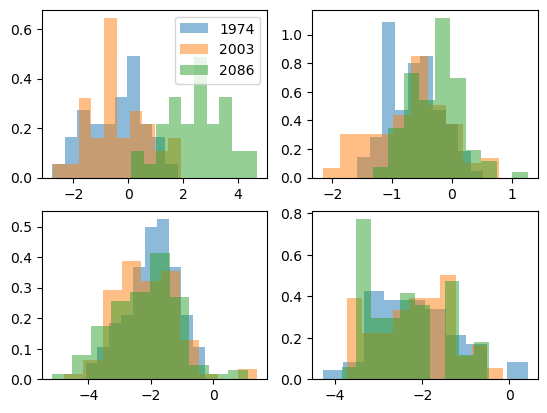

In [9]:
for i,mdl in enumerate(mdls):
    plt.subplot(221+i)
    for yr in msav['cesm2']:
        plt.hist([m[1] for m in msav[mdl][yr]],density=True,alpha=0.5,label=yr)
    if i==0:
        plt.legend()

In [10]:
ds

<xarray.Dataset>
Dimensions:    (year: 251, ens: 50)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
    height     float64 ...
  * ens        (ens) <U10 'mpi12.r001' 'mpi12.r002' ... 'mpi12.r050'
Data variables:
    NBP        (ens, year) float64 ...
    NBP_TROP   (ens, year) float64 ...
    PREC       (ens, year) float64 ...
    PREC_TROP  (ens, year) float64 ...
    TSA        (ens, year) float64 ...
    TSA_TROP   (ens, year) float64 ...
    SW         (ens, year) float64 ...
    SW_TROP    (ens, year) float64 ...
    RH         (ens, year) float64 ...
    RH_TROP    (ens, year) float64 ...

In [8]:
mdls=['cesm1','cesm2','mpige','mpi12']
ms={mdl:{} for mdl in mdls}
for mdl in mdls:
    if 'mpi' in mdl:
        la=xr.open_dataset('mpi_mask_grnlnd_antarc.nc').landarea
    else:
        la=xr.open_dataset('mask_grnlnd_antarc.nc').landarea
    latrop=la.where(abs(la.lat)<24)
    f='../data/globann/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)
    yys=[[1960,1989],[1989,2018],[2073,2099]]
    for yy in yys:
        ix=get_ix(ds,yy[0],yy[1])
        yr=int(np.floor(np.mean(yy)))
        
        cfs={}
        cfs['SW_TROP']=1e-9*latrop.sum().values
        cfs['TSA_TROP']=1
        cfs['NBP']=1e-9*la.sum().values*24*60*60*365
        
        xvs=['SW_TROP','TSA_TROP']
        
        
        x=np.vstack([cfs[v]*detrend_dim(ds[v].isel(year=ix),'year').values.ravel() for v in xvs]).T
        y=cfs['NBP']*detrend_dim(ds.NBP.isel(year=ix),'year').values.ravel()
        ms[mdl][yr]=reg2(x,y)

cesm1-1974-uni:  1.17   0.48   -1.46   -0.4   
cesm1-1974-biv:  0.98   0.42   -0.38   -0.12   
cesm1-2003-uni:  1.1   0.44   -1.41   -0.38   
cesm1-2003-biv:  0.91   0.37   -0.34   -0.1   
cesm1-2086-uni:  1.08   0.32   -0.02   -0.01   
cesm1-2086-biv:  2.63   0.67   2.52   0.57   
cesm2-1974-uni:  0.54   0.64   -1.21   -0.63   
cesm2-1974-biv:  0.33   0.47   -0.66   -0.42   
cesm2-2003-uni:  0.61   0.58   -1.33   -0.57   
cesm2-2003-biv:  0.36   0.39   -0.69   -0.35   
cesm2-2086-uni:  0.39   0.43   -0.69   -0.38   
cesm2-2086-biv:  0.29   0.34   -0.29   -0.17   
mpige-1974-uni:  1.91   0.79   -3.23   -0.8   
mpige-1974-biv:  1.03   0.62   -1.88   -0.65   
mpige-2003-uni:  1.76   0.77   -3.33   -0.79   
mpige-2003-biv:  0.78   0.51   -2.14   -0.66   
mpige-2086-uni:  1.47   0.75   -3.12   -0.78   
mpige-2086-biv:  0.53   0.41   -2.16   -0.67   
mpi12-1974-uni:  1.69   0.77   -2.96   -0.82   
mpi12-1974-biv:  0.59   0.44   -2.15   -0.74   
mpi12-2003-uni:  1.68   0.76   -2.98   -0.81  

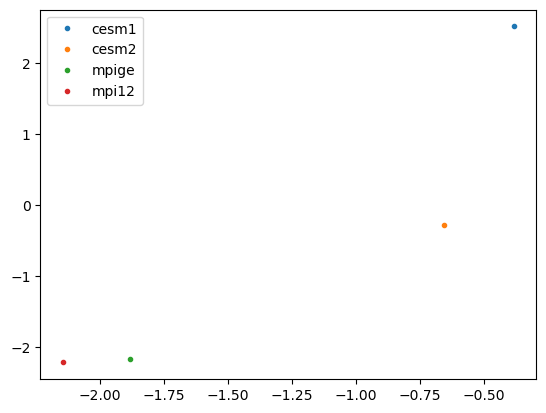

In [18]:
y1=1974
y2=2086
for mdl in mdls:
    plt.plot(ms[mdl][y1][3],ms[mdl][y2][3],'.',label=mdl)
plt.legend()

In [7]:
def reg2(x,y):
    ms=[]
    pp=mdl+'-'+str(yr)+'-uni:  '
    for i,v in enumerate(xvs):
        m,b,r,p,err=stats.linregress(x[:,i],y)
        pp+='{}   {}   '.format(np.round(m,2),np.round(r,2))
        ms.append(m)
    print(pp)
    lm=sm.OLS(y,x).fit()
    rs=[np.corrcoef(x[:,0],y-lm.params[1]*x[:,1])[0,1],
        np.corrcoef(x[:,1],y-lm.params[0]*x[:,0])[0,1]]
    pp=mdl+'-'+str(yr)+'-biv:  '
    for m,r in zip(lm.params,rs):
        pp+='{}   {}   '.format(np.round(m,2),np.round(r,2))
        ms.append(m)
    print(pp)

    return ms
    

cesm1-1974-uni:  1.13   0.67   -2.3   -0.75   
cesm1-1974-biv:  0.05   0.05   -2.22   -0.74   


cesm1-biv: 0.05  0.05  -2.22  -0.74  


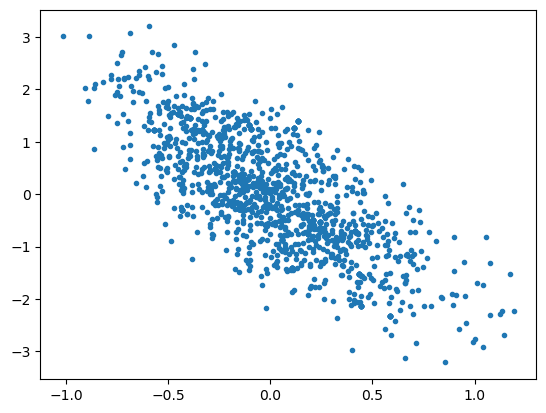

In [160]:
plt.plot(x[:,1],y-lm.params[0]*x[:,0],'.')

In [111]:
yrs=[1974,2003,2086]
yys=[[1960,1989],[1989,2018],[2073,2099]]
mdls=['cesm1','cesm2','mpige','mpi12']
m1s={mdl:{yr:[] for yr in yrs} for mdl in mdls}
m2s={mdl:{yr:[] for yr in yrs} for mdl in mdls}

In [112]:
yys=[[1960,1989],[1989,2018],[2073,2099]]
for mdl in mdls:
    if 'mpi' in mdl:
        la=xr.open_dataset('mpi_mask_grnlnd_antarc.nc').landarea
    else:
        la=xr.open_dataset('mask_grnlnd_antarc.nc').landarea
    latrop=la.where(abs(la.lat)<24)
    f='../data/globann/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)
    for yy in yys:
        ix=get_ix(ds,yy[0],yy[1])
        x1=1e-9*latrop.sum()*detrend_dim(ds.SW_TROP.isel(year=ix),'year')
        x2=detrend_dim(ds.TSA_TROP.isel(year=ix),'year')
        y=1e-9*la.sum()*cf*detrend_dim(ds.NBP.isel(year=ix),'year')
        yr=int(np.floor(np.mean(yy)))
        for ee in x1.ens:
            lm=sm.OLS(y.sel(ens=ee).values,np.vstack([x1.sel(ens=ee),x2.sel(ens=ee)]).T).fit()
            m1s[mdl][yr].append(lm.params[0])
            m2s[mdl][yr].append(lm.params[1])

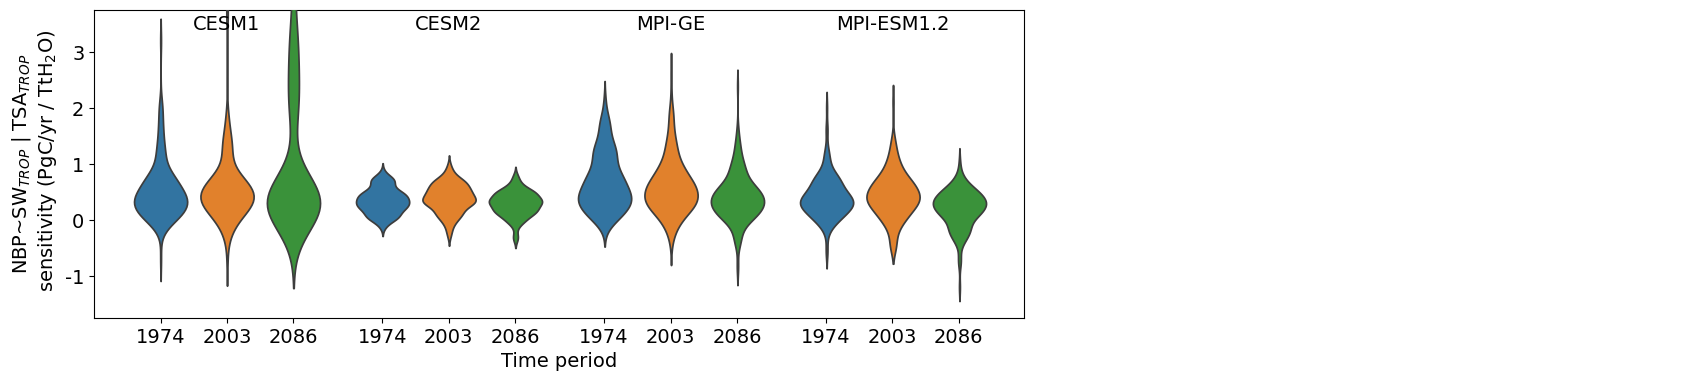

In [67]:
fig, ax1 = plt.subplots(ncols=1,figsize=[12,4])
marks=['<','>']
mnames={'cesm1':'CESM1','cesm2':'CESM2','mpige':'MPI-GE','mpi12':'MPI-ESM1.2'}
xshift=0.185
for i,mdl in enumerate(mdls):
    ax= fig.add_subplot(111, sharex=ax1, sharey=ax1, label="ax2")
    pos = ax.get_position()
    newpos = Bbox.from_bounds(pos.x0+i*xshift, pos.y0, pos.width, pos.height)
    ax.set_position(newpos)
    ax.axis('off')
    
    sns.violinplot(m1s[mdl],ax=ax,inner=None)
    plt.text(1,3.4,mnames[mdl],ha='center',fontsize=14)
    xs={yr:x for yr,x in zip(yrs,[-0.13,0.87,1.87])}
    

plt.xlim([-1,13])
xv=[i*3.338+j for i in range(4) for j in range(3)]
ax1.set_xticks(xv,np.tile(yrs,4),fontsize=14);
plt.ylim([-1.75,3.75])

yy=np.arange(-1,4)
ax1.set_yticks(yy,yy,fontsize=14)
ax1.set_ylabel('NBP~SW$_{TROP}$ | TSA$_{TROP}$ \n sensitivity (PgC/yr / TtH$_2$O)',fontsize=14);
ax1.set_xlabel('Time period',fontsize=14);
#plt.savefig('../figs/main/fig1.png',dpi=300,bbox_inches='tight')

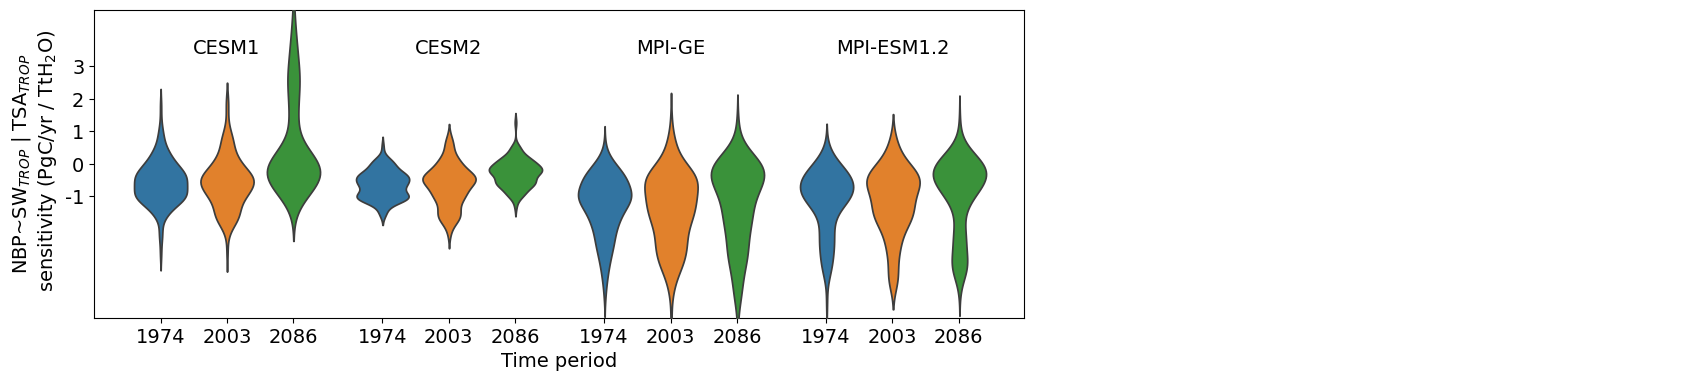

In [71]:
fig, ax1 = plt.subplots(ncols=1,figsize=[12,4])
marks=['<','>']
mnames={'cesm1':'CESM1','cesm2':'CESM2','mpige':'MPI-GE','mpi12':'MPI-ESM1.2'}
xshift=0.185
for i,mdl in enumerate(mdls):
    ax= fig.add_subplot(111, sharex=ax1, sharey=ax1, label="ax2")
    pos = ax.get_position()
    newpos = Bbox.from_bounds(pos.x0+i*xshift, pos.y0, pos.width, pos.height)
    ax.set_position(newpos)
    ax.axis('off')
    
    sns.violinplot(m2s[mdl],ax=ax,inner=None)
    plt.text(1,3.4,mnames[mdl],ha='center',fontsize=14)
    xs={yr:x for yr,x in zip(yrs,[-0.13,0.87,1.87])}
    

plt.xlim([-1,13])
xv=[i*3.338+j for i in range(4) for j in range(3)]
ax1.set_xticks(xv,np.tile(yrs,4),fontsize=14);
plt.ylim([-4.75,4.75])

yy=np.arange(-1,4)
ax1.set_yticks(yy,yy,fontsize=14)
ax1.set_ylabel('NBP~SW$_{TROP}$ | TSA$_{TROP}$ \n sensitivity (PgC/yr / TtH$_2$O)',fontsize=14);
ax1.set_xlabel('Time period',fontsize=14);
#plt.savefig('../figs/main/fig1.png',dpi=300,bbox_inches='tight')

In [98]:
xs={mdl:{} for mdl in mdls}
ys={mdl:{} for mdl in mdls}

In [114]:
yys=[[1960,1989],[1989,2018],[2073,2099]]
for mdl in mdls:
    if 'mpi' in mdl:
        la=xr.open_dataset('mpi_mask_grnlnd_antarc.nc').landarea
    else:
        la=xr.open_dataset('mask_grnlnd_antarc.nc').landarea
        xvs=['SW_TROP','TSA_TROP']
    latrop=la.where(abs(la.lat)<24)
    f='../data/globann/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)
    

    
    for yy in yys:
        yr=int(np.floor(np.mean(yy)))
        ix=get_ix(ds,yy[0],yy[1])
        
        xs[mdl][yr]=np.vstack([cfs[v]*detrend_dim(ds[v].isel(year=ix),'year').values.ravel() for v in xvs]).T
        ys[mdl][yr]=cfs['NBP']*detrend_dim(ds.NBP.isel(year=ix),'year').values.ravel()

In [116]:
yrs=[1974,2003,2086]
m1s={mdl:{} for mdl in mdls}
for mdl in mdls:
    for yr in yrs:
        lm=sm.OLS(ys[mdl][yr],xs[mdl][yr]).fit()
        m1s[mdl][yr]=lm.params[0]

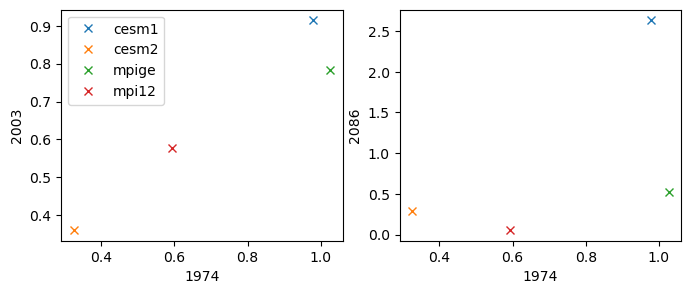

In [127]:
plt.figure(figsize=[8,3])
y1=1974
y2=2003
for y2 in [2003,2086]:
    plt.subplot(121+(y2>2003))
    for mdl in mdls:
        plt.plot(m1s[mdl][y1],m1s[mdl][y2],'x',label=mdl)
    #plt.plot([0.2,1.2],[0.2,1.2],'k:')   
    #plt.xlim([0.2,1.2])
    #plt.ylim([0.2,1.2])
    plt.xlabel(y1)
    plt.ylabel(y2)
    if y2==2003:
        plt.legend()


In [96]:
lm=sm.OLS(y,np.vstack(x).T).fit()

In [97]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.465
Model:                            OLS   Adj. R-squared (uncentered):              0.464
Method:                 Least Squares   F-statistic:                              1171.
Date:                Wed, 02 Oct 2024   Prob (F-statistic):                        0.00
Time:                        13:52:28   Log-Likelihood:                         -1317.5
No. Observations:                2700   AIC:                                      2639.
Df Residuals:                    2698   BIC:                                      2651.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3259      0.018     18.032      0.000       0.290       0.361
x2            -0.6571      0.041    -15.993      0.000      -0.738      -0.577
==============================================================================
Omnibus:                        6.791   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                6.658
Skew:                          -0.100   Prob(JB):                       0.0358
Kurtosis:                       2.862   Cond. No.                         3.86
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
xs={mdl:{} for mdl in mdls}
ys={mdl:{} for mdl in mdls}
for mdl in mdls:
    f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)
    for yy in yys:
        ix=get_ix(ds,yy[0],yy[1])
        midyear=int(np.floor(np.mean(yy)))
        xs[mdl][midyear]=detrend_dim(ds.SW_TROP.isel(year=ix),'year')
        ys[mdl][midyear]=cf*detrend_dim(ds.NBP.isel(year=ix),'year')

In [88]:
altsigs={mdl:{yr:{} for yr in yrs} for mdl in mdls}
for mdl in mdls:
    for yr1 in yrs:
        for yr2 in yrs:
            x=np.vstack([np.hstack([xs[mdl][yr1].values.ravel(),xs[mdl][yr2].values.ravel()]),
                         np.hstack([0*xs[mdl][yr1].values.ravel(),xs[mdl][yr2].values.ravel()])]).T
            y=np.hstack([ys[mdl][yr1].values.ravel(),ys[mdl][yr2].values.ravel()])
            lm=sm.OLS(y,x).fit()
            altsigs[mdl][yr1][yr2]=lm.pvalues[1]<0.05
            
            

In [95]:
mdl='CESM2'
f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
ds=xr.open_dataset(f)




In [99]:
x=[t for t in tsa]

In [118]:

m0ps={yr:[] for yr in yrs}
m1ps={yr:[] for yr in yrs}

for yy in yys:
    midyear=int(np.floor(np.mean(yy)))
    ix=get_ix(ds,yy[0],yy[1])
    tsa=detrend_dim(ds.TSA_TROP.isel(year=ix),'year')
    sw=detrend_dim(ds.SW_TROP.isel(year=ix),'year')
    nbp=cf*detrend_dim(ds.NBP.isel(year=ix),'year')
    
    
    for t,s,n in zip(tsa,sw,nbp):
        x=np.vstack([t,s]).T
        y=n.values
        lm=sm.OLS(y,x).fit()
        m0ps[midyear].append(lm.params[0])
        m1ps[midyear].append(lm.params[1])

In [123]:
stats.ttest_ind(m1ps[1974],m1ps[2003])

TtestResult(statistic=-1.2468450969211118, pvalue=0.2139272375357949, df=198.0)

In [126]:
stats.ttest_ind(m1ps[2003],m1ps[2086])

TtestResult(statistic=2.9309443324903004, pvalue=0.0037767112123526575, df=198.0)

<Axes: >

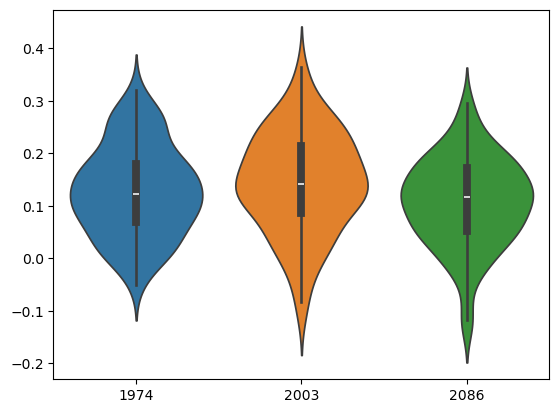

In [121]:
sns.violinplot(m1ps)

(array([ 3.,  1.,  6.,  8., 20., 21., 14., 18.,  6.,  3.]),
 array([-0.13125532, -0.08851808, -0.04578083, -0.00304358,  0.03969367,
         0.08243092,  0.12516817,  0.16790542,  0.21064267,  0.25337992,
         0.29611717]),
 <BarContainer object of 10 artists>)

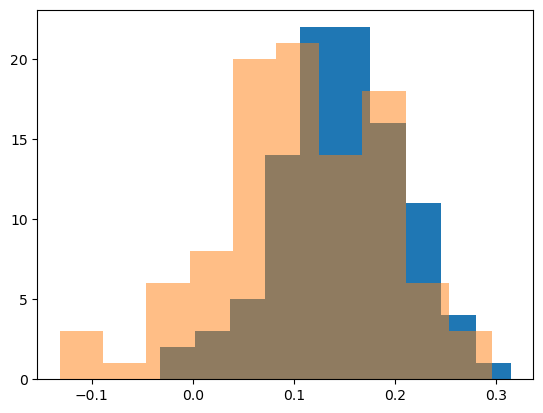

In [116]:
plt.hist(m1s)
plt.hist(m1ps,alpha=0.5)

In [90]:
for mdl in mdls:
    for yr1 in yrs:
        for yr2 in yrs:
            if yr1!=yr2:
                print(mdl,yr1,yr2,altsigs[mdl][yr1][yr2])

CESM1 1974 2003 False
CESM1 1974 2086 False
CESM1 2003 1974 False
CESM1 2003 2086 False
CESM1 2086 1974 False
CESM1 2086 2003 False
CESM2 1974 2003 True
CESM2 1974 2086 True
CESM2 2003 1974 True
CESM2 2003 2086 True
CESM2 2086 1974 True
CESM2 2086 2003 True
MPIGE 1974 2003 True
MPIGE 1974 2086 True
MPIGE 2003 1974 True
MPIGE 2003 2086 True
MPIGE 2086 1974 True
MPIGE 2086 2003 True
MPI12 1974 2003 False
MPI12 1974 2086 True
MPI12 2003 1974 False
MPI12 2003 2086 True
MPI12 2086 1974 True
MPI12 2086 2003 True


In [87]:
mdl='CESM2'
yr1=1974
yr2=2003

lm.pvalues[1]

0.0018932470768313512

In [84]:
y.shape

(5400,)

In [36]:
f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
ds=xr.open_dataset(f)
yy=yys[0]
ix=get_ix(ds,yy[0],yy[1])
midyear=int(np.floor(np.mean(yy)))
x=detrend_dim(ds.SW_TROP.isel(year=ix),'year')
y=cf*detrend_dim(ds.NBP.isel(year=ix),'year')

In [61]:
mdls=['CESM1','CESM2','MPIGE','MPI12']
yys=[[1960,1989],[1989,2018],[2073,2099]]
cf=24*60*60*365
ms={mdl:{} for mdl in mdls}
for mdl in mdls:
    print(mdl)
    f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)
    for yy in yys:
        ix=get_ix(ds,yy[0],yy[1])
        midyear=int(np.floor(np.mean(yy)))
        x=detrend_dim(ds.SW_TROP.isel(year=ix),'year')
        y=cf*detrend_dim(ds.NBP.isel(year=ix),'year')
        nens=len(x.ens)
        nb=int(np.round(5000/nens))
        rr=np.random.randint(27,size=[nens,nb,27])
        m=[[stats.linregress(x.isel(ens=i,year=r),y.isel(ens=i,year=r))[0] for r in rr[i,:,:]] for i in range(nens)]
        ms[mdl][midyear]=np.array(m).ravel()
    

CESM1
CESM2
MPIGE
MPI12


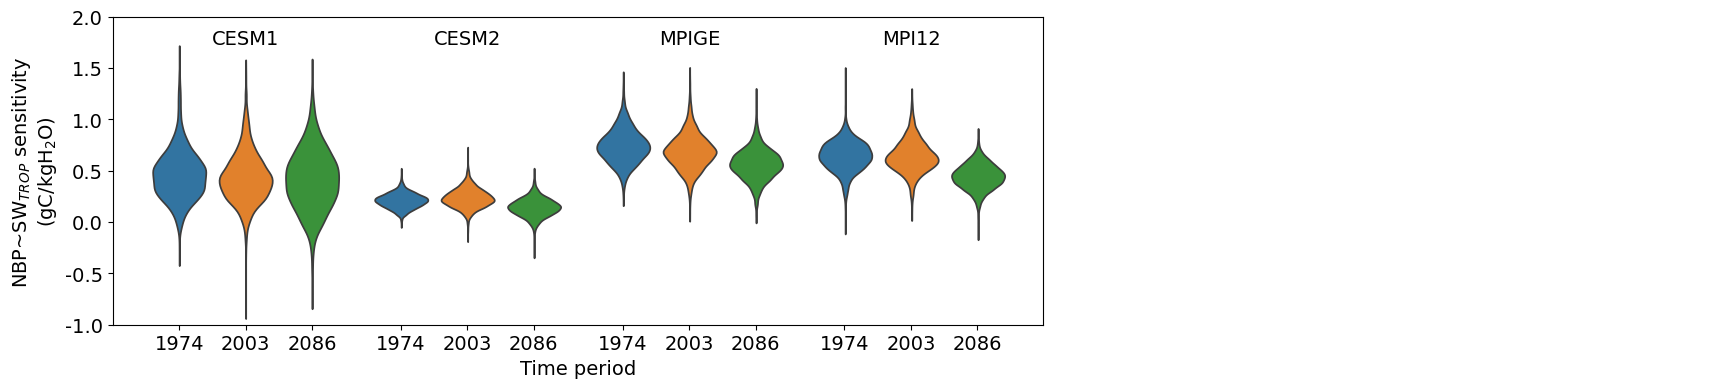

In [75]:
fig, ax1 = plt.subplots(ncols=1,figsize=[12,4])

xshift=0.185
for i,mdl in enumerate(mdls):
    ax= fig.add_subplot(111, sharex=ax1, sharey=ax1, label="ax2")
    pos = ax.get_position()
    newpos = Bbox.from_bounds(pos.x0+i*xshift, pos.y0, pos.width, pos.height)
    ax.set_position(newpos)
    ax.axis('off')
    
    sns.violinplot(ms[mdl],cut=0,ax=ax,inner=None)
    plt.text(1,1.73,mdl,ha='center',fontsize=14)
    
plt.xlim([-1,13])
xv=[i*3.338+j for i in range(4) for j in range(3)]
ax1.set_xticks(xv,np.tile([y for y in ms['CESM2']],4),fontsize=14);
plt.ylim([-1,2])

yy=np.arange(7)/2-1
ax1.set_yticks(yy,yy,fontsize=14)
ax1.set_ylabel('NBP~SW$_{TROP}$ sensitivity \n(gC/kgH$_2$O)',fontsize=14);
ax1.set_xlabel('Time period',fontsize=14);
plt.savefig('../figs/june/violins_nbp_swtrop_b5000.png',dpi=300,bbox_inches='tight')

In [30]:
max(ms['CESM1'][1974])

1.1635075386545566

In [22]:
cf=24*60*60*365
x=detrend_dim(ds.SW.sel(year=slice(1990,2004)),'year')
y=cf*detrend_dim(ds.NBP.sel(year=slice(1990,2004)),'year')



In [109]:
rvals=[stats.linregress(x,y)[2] for x,y in zip(x,y)]
mvals=[stats.linregress(x,y)[0] for x,y in zip(x,y)]

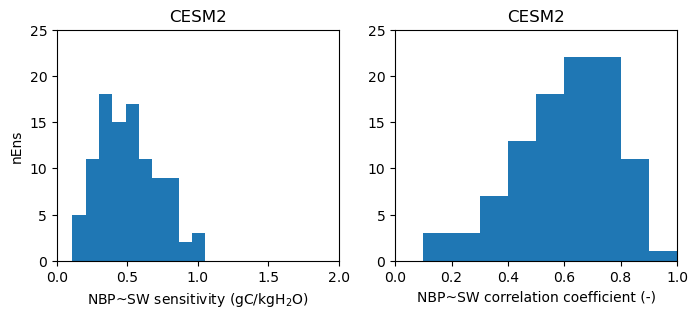

In [46]:
plt.figure(figsize=[8,3])
plt.subplot(121)
plt.hist(mvals)
plt.xlim([0,2])
plt.ylim([0,25])
plt.xlabel('NBP~SW sensitivity (gC/kgH$_2$O)');
plt.ylabel('nEns')
plt.title('CESM2');

plt.subplot(122)
plt.hist(rvals,np.arange(11)/10)
plt.xlim([0,1])
plt.ylim([0,25])
plt.xlabel('NBP~SW correlation coefficient (-)');
plt.title('CESM2');

### bootstrapping across the full ensemble seems to perform reasonably well

In [102]:
xx=x.values.ravel()
yy=y.values.ravel()
rr=np.random.randint(1500,size=[5000,15])

In [106]:
mvalsboot=[stats.linregress(xx[r],yy[r])[0] for r in rr]

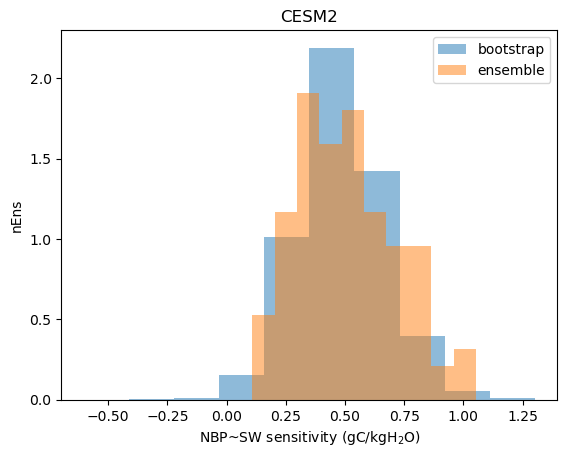

In [112]:
plt.hist(mvalsboot,density=True,alpha=0.5,label='bootstrap')
plt.hist(mvals,density=True,alpha=0.5,label='ensemble')
plt.legend()
plt.xlabel('NBP~SW sensitivity (gC/kgH$_2$O)');
plt.ylabel('nEns')
plt.title('CESM2');

### but bootstrapping a single member does not accurately bound the broader ensemble

In [118]:
cvals=[]
qqs=[0.025,0.975]
for i in range(100):
    xx=x.isel(ens=i)
    yy=y.isel(ens=i)
    rr=np.random.randint(15,size=[5000,15])
    m=[stats.linregress(xx[r],yy[r])[0] for r in rr]
    cvals.append(np.quantile(m,qqs))


In [60]:
cvals=[]
for i in range(100):
    lm=sm.OLS(y.isel(ens=i).values,x.isel(ens=i).values).fit()
    cvals.append(lm.conf_int()[0])

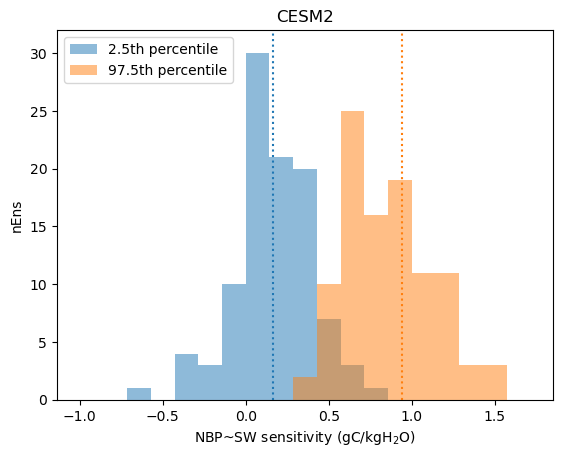

In [121]:
plt.hist(np.array(cvals)[:,0],np.arange(20)/7-1,alpha=0.5,label='2.5th percentile')
plt.hist(np.array(cvals)[:,1],np.arange(20)/7-1,alpha=0.5,label='97.5th percentile')
plt.plot([c[0],c[0]],[0,32],'C0:')
plt.plot([c[1],c[1]],[0,32],'C1:')
plt.ylim([0,32])
plt.legend()
plt.xlabel('NBP~SW sensitivity (gC/kgH$_2$O)')
plt.ylabel('nEns')
plt.title('CESM2');

### NBP looks a bit funky, especially in 2010

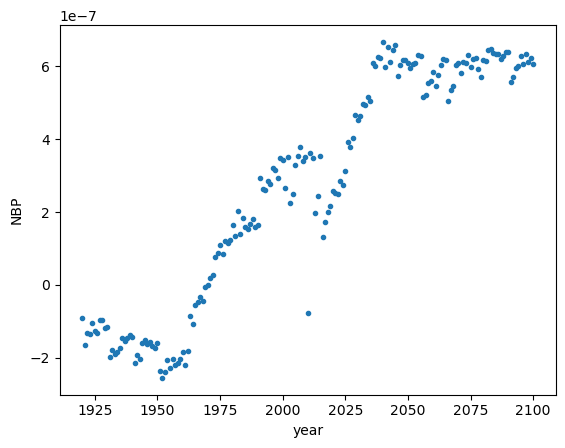

In [152]:
ds.NBP.mean(dim='ens').plot.line('.');

In [211]:
ix=get_ix(ds,1960,1989)
ny=int(ix.sum())
x=detrend_dim(ds.SW_TROP.isel(year=ix),'year').values.ravel()
y=cf*detrend_dim(ds.NBP.isel(year=ix),'year').values.ravel()
rr=np.random.randint(len(x),size=[5000,ny])
m0=[stats.linregress(x[r],y[r])[0] for r in rr]

In [212]:
ix=get_ix(ds,1989,2018)
ny=int(ix.sum())
x=detrend_dim(ds.SW_TROP.isel(year=ix),'year').values.ravel()
y=cf*detrend_dim(ds.NBP.isel(year=ix),'year').values.ravel()
rr=np.random.randint(len(x),size=[5000,ny])
m1=[stats.linregress(x[r],y[r])[0] for r in rr]

In [222]:
ix=get_ix(ds,1989,2018)
x=detrend_dim(ds.SW_TROP.isel(year=ix),'year')
y=cf*detrend_dim(ds.NBP.isel(year=ix),'year')
r=[stats.linregress(x,y)[2] for x,y in zip(x,y)]

(array([ 0.,  0.,  2.,  6., 15., 36., 28., 11.,  2.,  0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

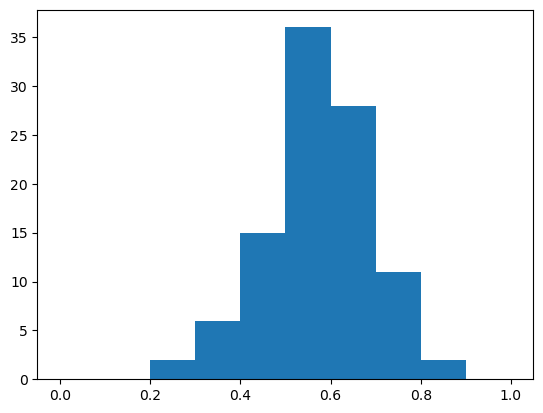

In [223]:
plt.hist(r,np.arange(11)/10)

(array([0.00743422, 0.01858555, 0.22674375, 1.33444271, 4.24494032,
        6.30793671, 4.20776921, 1.7173051 , 0.42375061, 0.09664488]),
 array([-0.07010829, -0.01630305,  0.03750218,  0.09130741,  0.14511264,
         0.19891787,  0.25272311,  0.30652834,  0.36033357,  0.4141388 ,
         0.46794404]),
 <BarContainer object of 10 artists>)

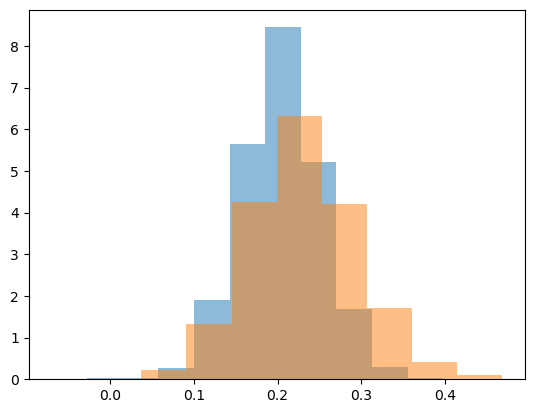

In [214]:
plt.hist(m0,alpha=0.5,density=True)
plt.hist(m1,alpha=0.5,density=True)

In [173]:
ix=get_ix(ds,1960,1989)
x=detrend_dim(ds.SW.isel(year=ix),'year')
y=cf*detrend_dim(ds.NBP.isel(year=ix),'year')
stats.linregress(x.values.ravel(),y.values.ravel())

LinregressResult(slope=0.39815564622033106, intercept=-3.054954235089567e-13, rvalue=0.5472464719570742, pvalue=8.340918532807814e-211, stderr=0.011723562630220874, intercept_stderr=0.06556531760623673)

In [246]:
mdls=['CESM1','CESM2','MPIGE','MPI12']

In [230]:


ix=get_ix(ds,1960,1989)
x=detrend_dim(ds.SW_TROP.isel(year=ix),'year')
y=cf*detrend_dim(ds.NBP.isel(year=ix),'year')

In [248]:
ms={mdl:{} for mdl in mdls}

In [273]:
yys=[[1960,1989],[1989,2018],[2073,2099]]
for mdl in mdls:
    f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)
    for yy in yys:
        ix=get_ix(ds,yy[0],yy[1])
        midyear=int(np.floor(np.mean(yy)))
        x=detrend_dim(ds.SW_TROP.isel(year=ix),'year')
        y=cf*detrend_dim(ds.NBP.isel(year=ix),'year')
        xx=x.values.ravel()
        yy=y.values.ravel()
        rr=np.random.randint(len(xx),size=[5000,27])
        m=[stats.linregress(xx[r],yy[r])[0] for r in rr]
        ms[mdl][midyear]=m
    

In [256]:
import pandas as pd

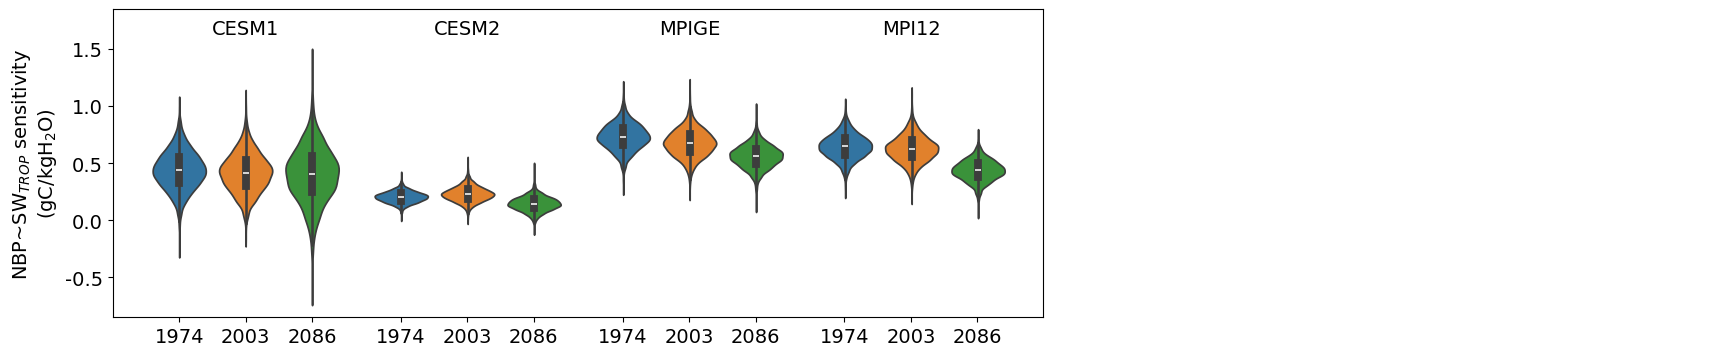

In [296]:
fig, ax1 = plt.subplots(ncols=1,figsize=[12,4])

xshift=0.185
for i,mdl in enumerate(mdls):
    ax= fig.add_subplot(111, sharex=ax1, sharey=ax1, label="ax2")
    pos = ax.get_position()
    newpos = Bbox.from_bounds(pos.x0+i*xshift, pos.y0, pos.width, pos.height)
    ax.set_position(newpos)
    ax.axis('off')
    
    sns.violinplot(ms[mdl],ax=ax)
    plt.text(1,1.63,mdl,ha='center',fontsize=14)
    
plt.xlim([-1,13])
xv=[i*3.338+j for i in range(4) for j in range(3)]
ax1.set_xticks(xv,np.tile([y for y in ms['CESM2']],4),fontsize=14);
plt.ylim([-0.85,1.85])

yy=np.arange(5)/2-0.5
ax1.set_yticks(yy,yy,fontsize=14)
ax1.set_ylabel('NBP~SW$_{TROP}$ sensitivity \n(gC/kgH$_2$O)',fontsize=14);
#plt.savefig('../figs/supp/violins_nbp_swtrop_corr.png',dpi=300,bbox_inches='tight')

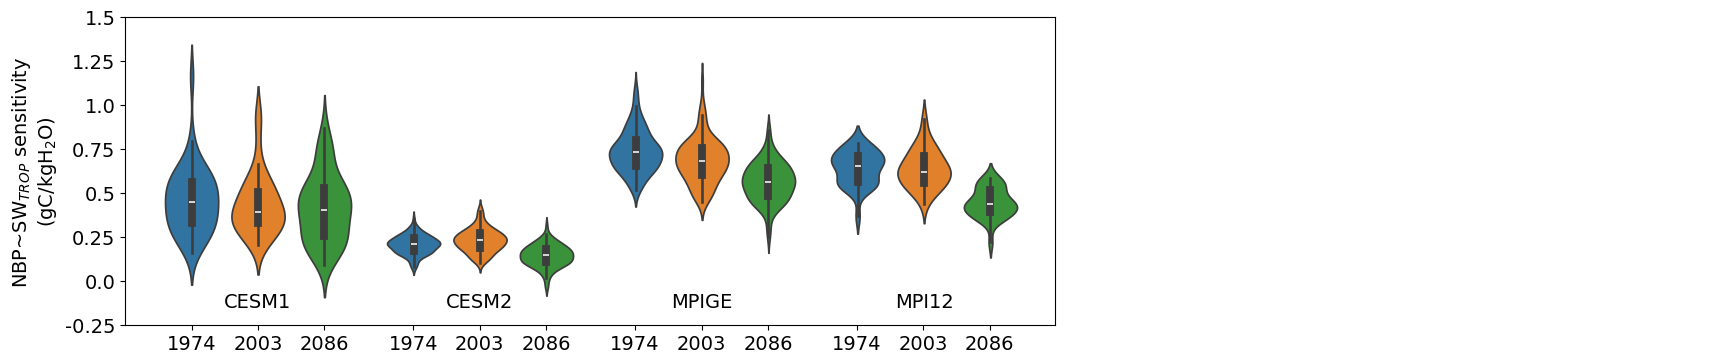

In [267]:
fig, ax1 = plt.subplots(ncols=1,figsize=[12,4])

xshift=0.185
for i,mdl in enumerate(mdls):
    ax= fig.add_subplot(111, sharex=ax1, sharey=ax1, label="ax2")
    pos = ax.get_position()
    newpos = Bbox.from_bounds(pos.x0+i*xshift, pos.y0, pos.width, pos.height)
    ax.set_position(newpos)
    ax.axis('off')
    
    sns.violinplot(ms[mdl],ax=ax)
    plt.text(1,-0.15,mdl,ha='center',fontsize=14)
    
plt.xlim([-1,13])
xv=[i*3.338+j for i in range(4) for j in range(3)]
ax1.set_xticks(xv,np.tile([y for y in ms['CESM2']],4),fontsize=14);
plt.ylim([-0.25,1.5])

yy=np.arange(8)/4-0.25
ax1.set_yticks(yy,yy,fontsize=14)
ax1.set_ylabel('NBP~SW$_{TROP}$ sensitivity \n(gC/kgH$_2$O)',fontsize=14);
#plt.savefig('../figs/supp/violins_nbp_swtrop_corr.png',dpi=300,bbox_inches='tight')

<Axes: >

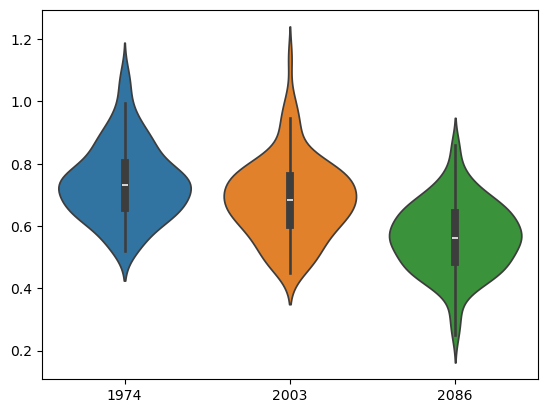

In [252]:
sns.violinplot(ms['CESM2'])

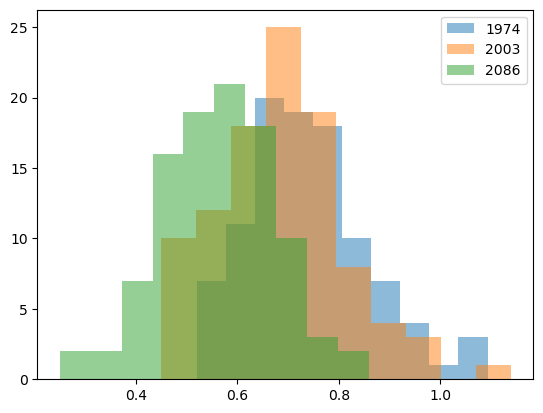

In [244]:
for m,yy in zip(ms,yys):
    midyear=int(np.floor(np.mean(yy)))
    plt.hist(m,alpha=0.5,label=midyear)
plt.legend()